# Simulated Lyman-n forest spectra

In [1]:
%matplotlib inline
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
from scipy.integrate import quad
import astropy.constants as const
import astropy.units as u
import h5py

from numba import double
from numba.decorators import jit, autojit

In [2]:
c = const.c.to(u.km / u.s).value # km/s

##  Load in z = 2.45 simulation data

Note: It has already been converted to hdf5 using `simdata_to_HDF5.ipynb`

We want to average over 2000 random sightlines of 50 boxes (files) across. In order to do this I am creating a (50, 2000) array of random indices. 

Can set `step` to speed up code by skipping rows


### read in data and set global variables

In [3]:
f = h5py.File('../../../Data/z245.hdf5', 'r')

# speed up code by making bigger steps through data
step = 100

# make a velocity array with the correspoding length and delta v
dv = (f['z2.45'][1, 1, 0] - f['z2.45'][1, 0, 0])*step

tau_HILya_data = np.asarray(f['z2.45'][:, ::step, :], dtype=np.float64)
n_HI_data = np.asarray(f['z2.45'][:, ::step, :], dtype=np.float64)

In [4]:
tau_HILya_data.shape

(2000, 30, 10)

In [5]:
num_files = tau_HILya_data.shape[0]
num_rows = tau_HILya_data.shape[1]
num_cells = 50
num_lines = 50 # number of Lyman transitions per Haiman et al 2000(?)

In [6]:
# make random indices array
# range from 0, 2000, in a 50 x 2000 shape
idx = np.random.randint(num_files, size=(num_cells, num_files))

### `tau_HILya` is now a 2000x150000 array (2000 sightlines by 50*num_files)

### each sightline is a composed of 50 random files stacked together (flattened).

In [7]:
tau_HILya = tau_HILya_data[idx,:,1].reshape(num_files,num_cells*num_rows)

In [8]:
def make_stacks(data, num_files, num_cells, num_rows):
    idx = np.random.randint(num_files, size=(num_cells, num_files))
    return data[idx,:,1].reshape(num_files,num_cells*num_rows)

### Useful functions to compute where in an array are the values equal

In [9]:
def find_nearest(array,value):
    idx = (np.fabs(array-value)).argmin()
    return idx

@jit
def vec_find_nearest(array, values):
    idxarr = np.empty_like(values, dtype=np.int32)
    for i in xrange(len(values)):
        idxarr[i] = (np.fabs(array-values[i])).argmin()
    return idxarr

# Lyman continuum

In [10]:
# compute the wavlengths of the transitions
def lyman_lambda(nmax):
    R_h = const.Ryd.to(1 / u.Angstrom).value # Rydberg constant in 1 /angstroms
    return (R_h*(1 - (1/nmax**2)))**-1

lyman_wav = np.vectorize(lyman_lambda)

# compute the oscillator strengths
def gf_1n(nn):
    """ A function to calculate the oscillator strengths of of the Lyman series (n'=1).
        
        Reference: RL equation 10.46 (p.281)
    """
    if nn > 1.9:
        gf = (2**9 * nn**5 * (nn-1)**(2*nn-4)) / (3*(nn+1)**(2*nn+4))
        return gf
    else:
        print "must input integer >= 2"

gf_1n = np.vectorize(gf_1n)

## Calclutate Column density:

From Rybicki & Lightman eq 10.70, using the line-center cross section for each atom, neglecting stimulated emission:

$$ \tau = N \sigma

$$ \sigma_{\nu_{0}} = \frac{\pi e^2}{mc} f_{12} \frac{1}{\Delta \nu_{D} \sqrt{\pi}} $$ 

and integrating over $\nu$ gives:

$$ \sigma_{\nu_{0}} = \frac{\pi e^2}{mc} f_{12} $$

then: 

$$ N_{HI} = \frac{\Delta v_i \tau_{Ly\alpha} mc}{f_{12} \pi e^2} $$

We need this to compute the Lyman continuum optical depth since there is no spacial information in the data, only velocity. 

Note: $f_{12} = \frac{gf_{12}}{2}$ where $g = 2$ is the degeneracy of the electron.

In [11]:
@jit
def make_column_density(t_HILya):
    m_h = const.m_p.cgs.value
    e = const.e.gauss.value
    m_e = const.m_e.cgs.value
    c_cmsec = const.c.cgs.value
    c_kmsec = const.c.to(u.km / u.s).value
    lyalpha = lyman_lambda(2)
    nuLya = c_cmsec/(lyalpha*1e-8)  #make this prettier!
    dnu = nuLya*dv/c_kmsec
    
    constants = (dnu*m_e*c_cmsec/(np.pi*e**2 * gf_1n(2)/2))
    # 1.6e17 should equal give tau 1
    
    # print "for testing: ", m_e, e, nuLya, dnu, c_cmsec, c_kmsec,  constants 
    nfiles = t_HILya.shape[0]
    nwaves = t_HILya.shape[1]
    
    print(lyman_lambda(2), gf_1n(2)/2,constants)
    
    N_HI = np.empty_like(t_HILya, dtype=np.float64)
    for i in xrange(nfiles):
        for j in xrange(nwaves):
            N_HI[i,j] = t_HILya[i,j]*constants
    return N_HI

In [12]:
N_HI = make_column_density(tau_HILya)

(1215.0227340678864, 0.4161967179799827, 62893892974789.125)



/Users/mwilde/anaconda/lib/python2.7/site-packages/numba/dataflow.py:297: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


### Compute the wavlength as its redshifted across the sightline

$$ \lambda \approx \big(1 + \frac{dv}{c}\big)^{N} $$

$$ \lambda \approx N\big(1 + \frac{dv}{c}\big) $$

In [13]:
# create emitted wavelength array
wav_min = 800.0
wav_em = np.zeros_like(tau_HILya[1])
wav_em[0] = wav_min
for i in xrange(1, tau_HILya.shape[1]):
    wav_em[i] = wav_em[i-1]*(1 + dv/c)

In [14]:
@jit
def fast_wave_sum(wave_arr, col_dens):
    """ 
    A function to pre-compute the sum over wavelengths used in tau_bf.
    
    input: wavelength array
    
    returns: summed slices of wavelength array
    
    NOTE: uses Numba (@jit) to speed up over 100x
    
    """
    lymanlimit = 911.267050642
    imax = find_nearest(wave_arr, lymanlimit)
    # tmp = np.ones_like(wave_arr)
    tmp = np.zeros_like(wave_arr)
    sigma0 = 6.30e-18
    ll = lymanlimit*lymanlimit*lymanlimit
    for n in xrange(col_dens.shape[0]):
        for i in xrange(len(wave_arr)):
            # ~4 times faster to multipy instead of power.
            # @jit makes this 4 times faster still. 
            tmp[i] = sigma0*np.sum(wave_arr[i:imax]*wave_arr[i:imax]*wave_arr[i:imax]*col_dens[n,i:imax])/ll
    return tmp
    """    for i in xrange(len(wave_arr)):
        for j in xrange(i,imax):
        # ~4 times faster to multipy instead of power.
        # @jit makes this 4 times faster still. 
            tmp[j] += wave_arr[j]*wave_arr[j]*wave_arr[j]
        tmp[i] *= sigma0/ll
    return tmp"""
@jit
def tau_bf(wave_arr, col_dens):
    """ 
    A function to compute the bound free opacity below the lyman limit.
    
    input: wavelength array, N_HI array (expected to be a nfiles x nrows)
    
    return: nfiles x nrows array of the bf optial depth
    
    NOTE: uses Numba (@jit) to speed it up over 100x
    """
    # col_dens = np.ones_like(col_dens)*1e14 # diagnostic
    # w = fast_wave_sum(wave_arr)
    lymanlimit = 911.267050642
    imax = find_nearest(wave_arr, lymanlimit)
    ll3 = lymanlimit*lymanlimit*lymanlimit
    num_file = col_dens.shape[0]
    num_row = col_dens.shape[1]
    sigma0 = 6.30e-18
    t_bf = np.empty((num_file, num_row), dtype=np.float64)
    for j in xrange(num_file):
        for i in xrange(num_row):
            t_bf[j,i] = sigma0*np.sum(wave_arr[i:imax]*wave_arr[i:imax]*wave_arr[i:imax]*col_dens[j,i:imax])/ll3
    return t_bf

In [15]:
t_bf = tau_bf(wav_em, N_HI)

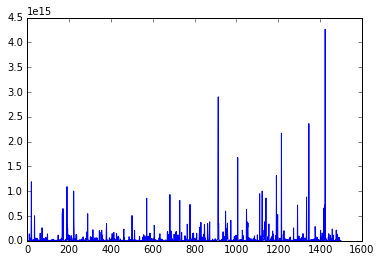

In [16]:
plt.plot(N_HI[100,:])
plt.show()

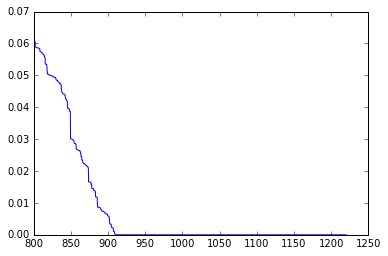

In [17]:
plt.plot(wav_em, t_bf[6,:])

## Add the Lyman-n Forest

$ \tau_{n} = \frac{gf_{1n}}{gf_{Ly\alpha}} \tau_{Ly\alpha} = f_n\tau_{Ly\alpha}$

This function computes the lyman transitions wavelength, finds the corresponding index and adds the opacity due to that line to the total opacity. 

In [18]:
@jit
def tau_HILyn(wave_em, t_HILya, nlines, debug=False):
    """ This function computes the Lyman-n forest opacity.
    
        input: emitted wavelength array, Lyman alpha opacity array, number of transitions
        
        returns: array of opacity in the same shape as tau_HILya
    """
    # array of oscillator strengths
    # go backwards since f_n,lambda_n start at lyman alpha
    f_n = (gf_1n(np.arange(2,nlines+2))/gf_1n(2))[::-1]
    
    # array of transition wavelengths
    lambda_n = lyman_lambda(np.arange(2,nlines+2))[::-1]
    
    nfiles = t_HILya.shape[0]
    
    lymanlimit = 911.267050642
    imax = find_nearest(wave_em, lymanlimit)

    # make an empty array to add in the Lyman alpha opacity
    tau_n = np.zeros_like(t_HILya)
    
    # where does wave_em == lyman-n line
    iarr = vec_find_nearest(wave_em,lambda_n)
    
    # good for debugging:
    tau_Ly = np.ones_like(t_HILya) 
    # print(f_n,iarr, t_HILya[0,iarr[0]]*f_n[0], wave_em[iarr])
    
    for n in xrange(nfiles):
        # do it for each sightline
        for i in range(nlines):
            
            if debug == False:
                # stack the opacity onto the opacity array at the index
                # where wavelength == nth lyman line
                tau_n[n,:iarr[i]] += t_HILya[n,:iarr[i]]*f_n[i]
            else:
                # good for debugging:
                tau_n[n,:iarr[i]] += tau_Ly[n,:iarr[i]]*f_n[i]
            
            
    return tau_n

In [19]:
t_Ly = tau_HILyn(wav_em, tau_HILya, num_lines)

What does a random sightlines Lyman-n opacity looks like:

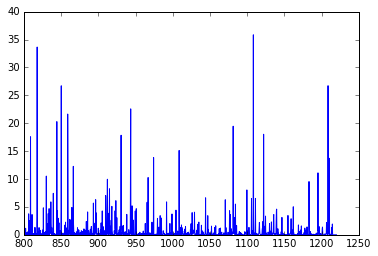

In [20]:
plt.plot(wav_em, t_Ly[9,:], label=i)
plt.show()

What does a random sightlines combined (Lyman-n & continuum) opacity looks like:

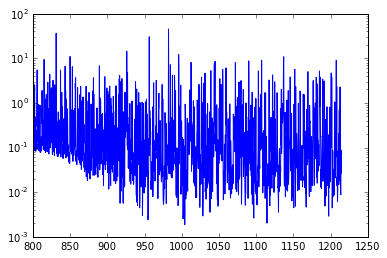

In [21]:
plt.semilogy(wav_em, t_bf[1,:] + t_Ly[2,:])
plt.show()

Compute the average flux over the 2000 sightlines

$$ f = \langle e^{-\tau_{bf+bb}} \rangle $$

### Plot the average spectrum and overlay an individual sightline for comparison. 

In [22]:
tau_tot = t_Ly + t_bf
tau_tot_slice = t_Ly[1,:] + t_bf[399,:]
# np.mean more accurate with float 64
flux = np.mean(np.exp(-tau_tot), axis=0, dtype=np.float64)
flux_slice = np.exp(-tau_tot_slice)

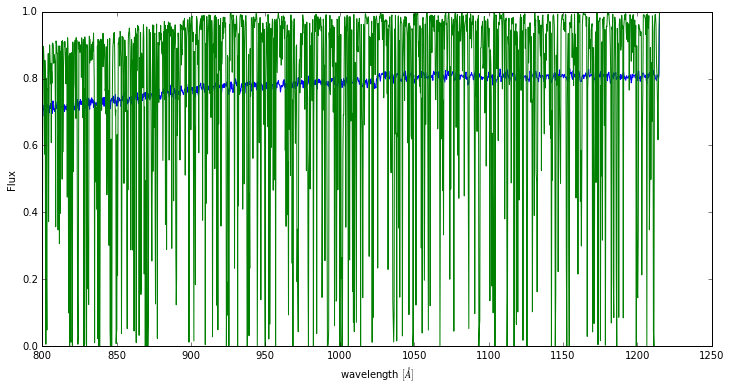

In [23]:
plt.figure(figsize=(12,6))
plt.plot(wav_em, flux)
plt.plot(wav_em, flux_slice)
plt.xlabel(r"wavelength $[\AA]$")
plt.ylabel(r"Flux")
plt.show()

# ToDo: 
 - add a mode to include redshift evolution. ie.: after so many boxes shift to a lower redshift
 
 - artificially put down column densities from a simplified $N_{HI}$ distribution drawn from a poisson distribution a guassian profile of width 30 km/s
 


Matt:

number of clusters per bin (N_HI = 10^12.5 to 10^17) = $f L \Delta N_{HI}$

make the clouds gaussian with a width of 20km/s